In [3]:
from itertools import pairwise
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

data="../data/ODcounts_calibration.xlsx"
raw_data = pd.read_excel(data)

# Clean data
raw_data['OD600 (1-cm)'] /= raw_data["Scale_OD"]
raw_data["Mean_cells"] = raw_data["Cells per ml, cyto"] # (raw_data["Cells per ml, cyto"] + raw_data["Cells per ml, plate counts"]) / 2
raw_data = raw_data.sort_values("OD600 (1-cm)")

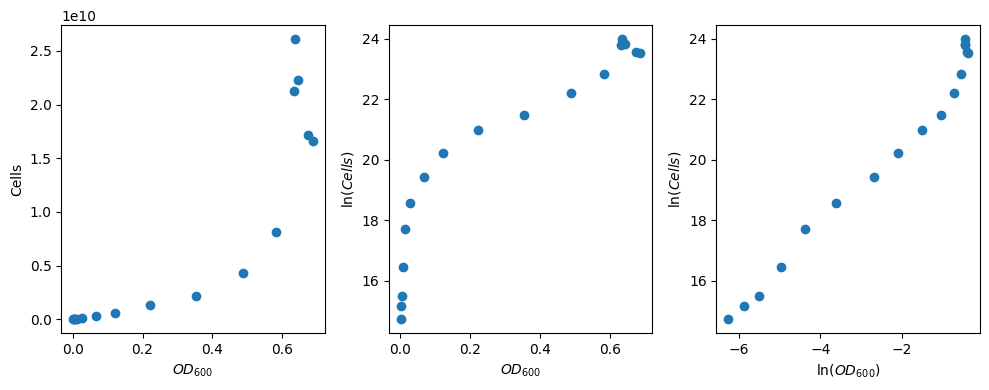

In [4]:
fig, (lin_ax, logy_ax, loglog_ax) = plt.subplots(1, 3)

od = raw_data['OD600 (1-cm)'].values.reshape(-1,1)
cells = raw_data["Mean_cells"].values.reshape(-1,1)

lin_ax.scatter(od, cells)
logy_ax.scatter(od, np.log(cells))
loglog_ax.scatter(np.log(od), np.log(cells))

lin_ax.set_xlabel("$OD_{600}$")
lin_ax.set_ylabel("Cells")
logy_ax.set_xlabel("$OD_{600}$")
logy_ax.set_ylabel("$\\ln(Cells)$")
loglog_ax.set_xlabel("$\\ln(OD_{600})$")
loglog_ax.set_ylabel("$\\ln(Cells)$")

fig.set_size_inches(10, 4)
fig.tight_layout()

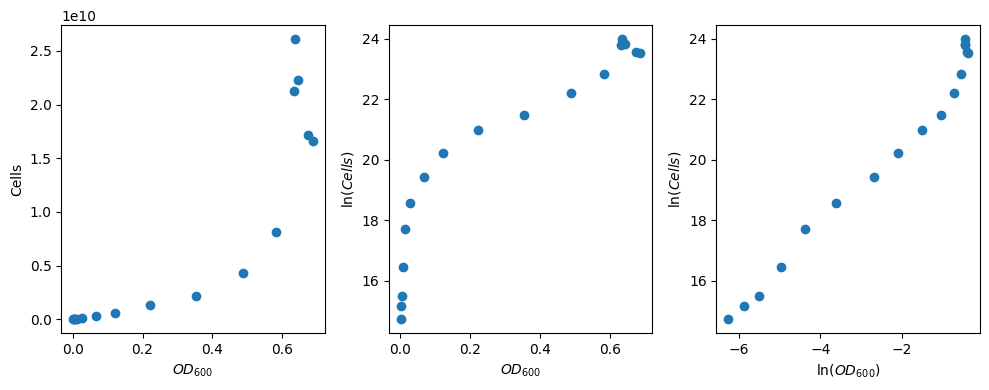

In [5]:
# Throw out outlier point
clean_data = raw_data[np.log(raw_data["Mean_cells"]) >= 13]

od = clean_data['OD600 (1-cm)'].values.reshape(-1,1)
cells = clean_data["Mean_cells"].values.reshape(-1,1)

fig, (lin_ax, logy_ax, loglog_ax) = plt.subplots(1, 3)

lin_ax.scatter(od, cells)
logy_ax.scatter(od, np.log(cells))
loglog_ax.scatter(np.log(od), np.log(cells))

lin_ax.set_xlabel("$OD_{600}$")
lin_ax.set_ylabel("Cells")
logy_ax.set_xlabel("$OD_{600}$")
logy_ax.set_ylabel("$\\ln(Cells)$")
loglog_ax.set_xlabel("$\\ln(OD_{600})$")
loglog_ax.set_ylabel("$\\ln(Cells)$")

fig.set_size_inches(10, 4)
fig.tight_layout()

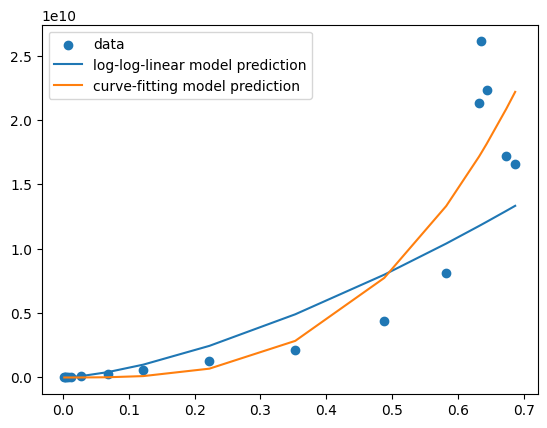

In [6]:
# Evaluate a log-log fit
loglog_model = LinearRegression()
loglog_model.fit(np.log(od), np.log(cells))
def model_form(od, a, b): return a * od**b


(a, b), pcov = curve_fit(model_form, od.flatten(), cells.flatten(),
                         p0=(np.exp(loglog_model.intercept_[0]), loglog_model.coef_[0, 0]))

pred_lm = np.exp(loglog_model.predict(np.log(od)))
pred_curve = model_form(od, a, b)

fig, ax = plt.subplots()
ax.scatter(od, cells, label="data")
ax.plot(od, pred_lm, label="log-log-linear model prediction")
ax.plot(od, pred_curve, label="curve-fitting model prediction")
ax.legend()


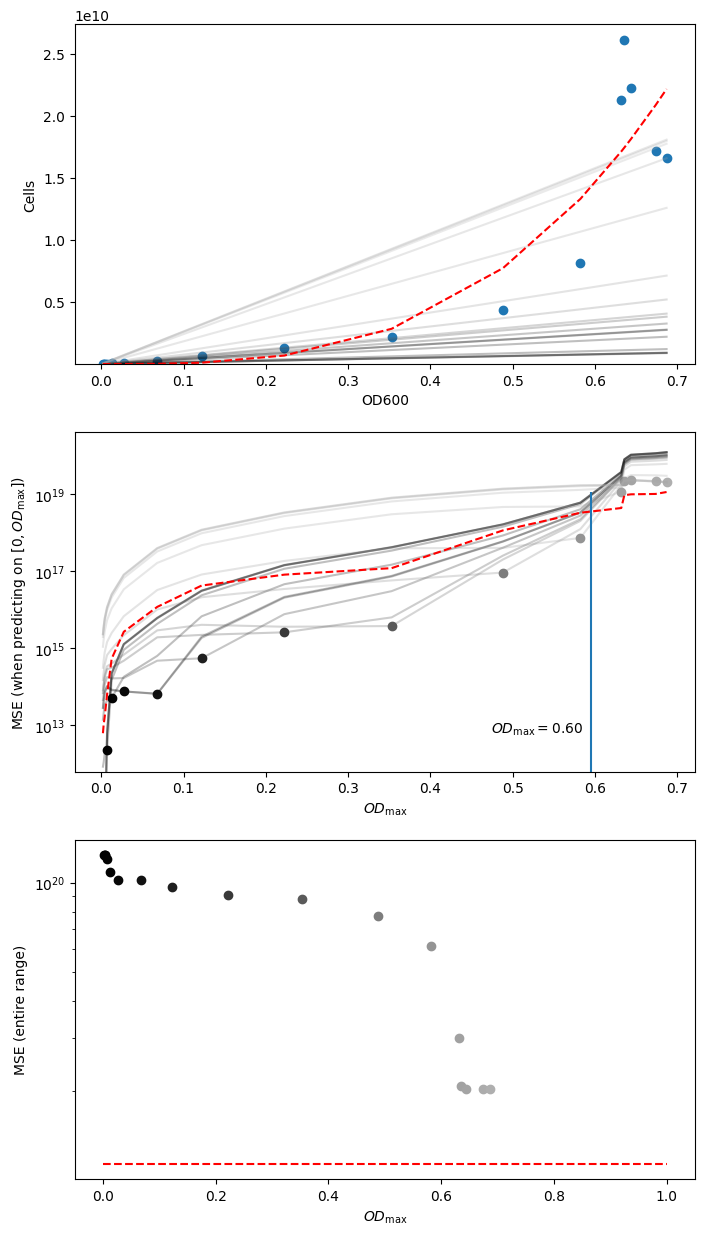

In [7]:
# Test performance of linear regressions as a function of cutoff for linear range

# Fit the restricted linear models with no intercept:
threshold = clean_data['OD600 (1-cm)']
models = {}
loglog_mse = []
for linear_max in threshold:
    linear_range_data = clean_data[clean_data['OD600 (1-cm)'] <= linear_max]

    x = linear_range_data['OD600 (1-cm)'].values.reshape(-1, 1)
    y = linear_range_data["Mean_cells"].values.reshape(-1, 1)

    lm = LinearRegression(fit_intercept=False)
    lm.fit(x, y)

    models[linear_max] = lm

    loglog_mse.append(mean_squared_error(y, model_form(x, a, b)))

# Do plots
fig, (fit_ax, mse_odmax_ax, mse_ax) = plt.subplots(3, 1)

# Plot fits
for thresh, lm in models.items():
    fit_ax.plot(od, lm.predict(od),
                label=f"$OD_{{\\max}} = {thresh:.3f}$", color=str(thresh), alpha=0.25)
fit_ax.plot(od, model_form(od, a, b),
            "r--", label="log-log fit")
fit_ax.scatter(od, clean_data["Mean_cells"])

# Plot MSEs for [0, OD_max]
min_mses = {}
for thresh, lm in models.items():
    mse_over_range = []
    for linear_max in threshold:
        linear_range_data = clean_data[clean_data['OD600 (1-cm)']
                                       <= linear_max]
        x = linear_range_data['OD600 (1-cm)'].values.reshape(-1, 1)
        y = linear_range_data["Mean_cells"].values.reshape(-1, 1)

        lm_pred = lm.predict(x)
        err = mean_squared_error(y, lm_pred)
        mse_over_range.append(err)

        if linear_max == thresh:
            mse_odmax_ax.scatter(thresh, err, color=str(thresh))
            min_mses[thresh] = err

    mse_odmax_ax.plot(threshold, mse_over_range,
                      label=f"linear ($OD_{{\\max}} = {thresh:.3f}$)",
                      color=str(thresh),
                      alpha=0.25)
mse_odmax_ax.plot(threshold, loglog_mse, color="r",
                  linestyle="dashed", label="log-log fit")

# Find and plot point of intersection
crossover_point = 0
for (((odmax_curr, err_curr),
     (odmax_next, err_next)),
     (curve_mse_curr, curve_mse_next)) in zip(pairwise(min_mses.items()), pairwise(loglog_mse)):
    
    if err_curr < curve_mse_curr and err_next > curve_mse_next:
        interval = odmax_next - odmax_curr
        slope_linear = (err_next - err_curr) / interval
        slope_curve = (curve_mse_next - curve_mse_curr) / interval
        crossover_point = odmax_curr + (curve_mse_curr - err_curr) / (slope_linear - slope_curve)
mse_odmax_ax.vlines(crossover_point, 0, max(loglog_mse))
mse_odmax_ax.text(crossover_point - 0.01,
                  min(loglog_mse),
                  f"$OD_{{\\max}} = {crossover_point : .2f}$",
                  horizontalalignment="right")

# Plot MSEs on the entire range of ODs
for (thresh, lm) in models.items():
    err = mean_squared_error(cells, lm.predict(od))
    mse_ax.scatter(thresh,
                   err,
                   label=f"linear ($OD_{{\\max}} = {thresh:.3f}$)",
                   color=str(thresh))
mse_curvefit = mean_squared_error(cells, model_form(od, a, b))
mse_ax.hlines(mse_curvefit, 0, 1.0, color="r", linestyles="dashed")

fit_ax.set_xlabel("OD600")
fit_ax.set_ylabel("Cells")
fit_ax.set_ylim(1e2, fit_ax.get_ylim()[1])

mse_odmax_ax.set_ylabel("MSE (when predicting on $[0, OD_{\\max}]$)")
mse_odmax_ax.set_xlabel("$OD_{\\max}$")
mse_odmax_ax.set_yscale("log")
mse_odmax_ax.set_ylim(min(loglog_mse) / 10, mse_odmax_ax.get_ylim()[1])

mse_ax.set_ylabel("MSE (entire range)")
mse_ax.set_xlabel("$OD_{\\max}$")
mse_ax.set_yscale("log")

fig.set_size_inches(8, 15)


The log-log curve-fit model outperforms restricted linear fits from $OD_{\max} \approx 0.60$ onwards.
Thus, we proceed using the following calibration:

$$
\begin{align*}
\text{\# Cells}(\text{OD}_{600}) = \begin{cases} c\cdot \text{OD}_{600} && \text{OD}_{600} \le 0.60\\
                                                 a\cdot \text{OD}_{600}^b && \text{OD}_{600} > 0.60\\
\end{cases}
\end{align*}
$$

Where $a, b, c$ are as follows:

In [8]:
final_lm = LinearRegression(fit_intercept=False)

data_60 = clean_data[clean_data["OD600 (1-cm)"] <= crossover_point]
od_60 = data_60["OD600 (1-cm)"].values.reshape(-1, 1)
cells_60 = data_60["Mean_cells"].values.reshape(-1, 1)

final_lm.fit(od_60, cells_60)

print(f"c = {final_lm.coef_[0, 0]}")
print(f"a = {a}")
print(f"b = {b}")

c = 10380840912.72552
a = 70547415991.58136
b = 3.0835136505779954


Text(0, 0.5, 'Cells')

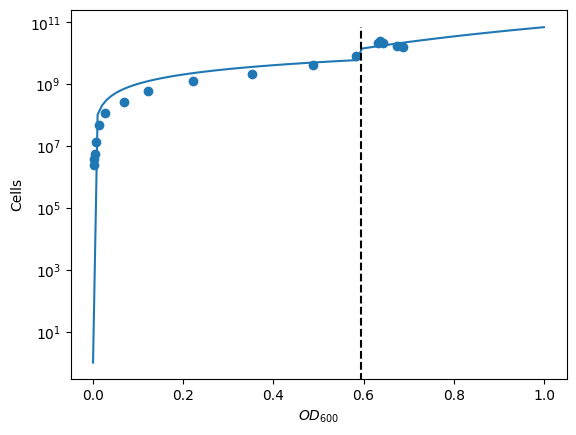

In [9]:
def predict_cells_from_OD(od):
    if not isinstance(od, np.ndarray):
        od = np.array(od)
    if len(od.shape) == 1:
        od = od.reshape(-1, 1)
    
    return np.where(od <= crossover_point, np.clip(final_lm.predict(od), 1, None), model_form(od, a, b))

x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, predict_cells_from_OD(x))
ax.vlines(crossover_point, *ax.get_ylim(), color="k", linestyles="dashed")
ax.scatter(od, cells)
ax.set_yscale("log")
ax.set_xlabel("$OD_{600}$")
ax.set_ylabel("Cells")

This looks decent, but let's estimate the best $OD_{\max}$ for the linear range more robustly using cross-validation.

I used K-fold cross-validation. Before this I tried LOOCV but it handled the large scale of the output range badly, and had some strange behavior that I think can be attributed to its higher variance. To score the models, I took the log of the true and predicted values before calculating the MSE. This allowed me to account for the vastly varying orders of magnitude without unfairly weighing the contributions from errors in the high range.

In [87]:
class CellCountRegressor:
    def __init__(self, crossover=None, a=None, b=None):
        self.crossover = np.Infinity if crossover is None else crossover
        self.a = 0 if a is None else a
        self.b = 0 if b is None else b

        self.lm = LinearRegression(fit_intercept=False)

    def _format_data(self, data):
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        if len(data.shape) == 1:
            data = data.reshape(-1, 1)
        return data

    def _train_linear(self, x, y):
        self.lm.fit(x, y)

    def _train_curve(self, x, y):
        # Use log-log linear model as initialization
        # for the curve-fitting optimization
        guess_model = LinearRegression()
        guess_model.fit(np.log(x), np.log(y))
        intercept = guess_model.intercept_[0]
        slope = guess_model.coef_[0, 0]

        # Do curve fitting
        def model_form(od, a, b): return a * od**b
        (self.a, self.b), self.pcov = curve_fit(model_form,
                                                x.flatten(),
                                                y.flatten(),
                                                p0=(np.exp(intercept), slope))

    def train(self, x, y):
        x = self._format_data(x)
        y = self._format_data(y)

        linear_mask = x <= self.crossover
        linear_range_x = self._format_data(x[linear_mask])
        linear_range_y = self._format_data(y[linear_mask])

        # train linear model
        if linear_range_x.size > 0:
            self._train_linear(linear_range_x, linear_range_y)
        else:
            # just fit a flat line...idk if there's something
            # smarter to do here
            self._train_linear([[1]], [[0]])

        # train curve-fit model
        self._train_curve(x, y)

    def _predict_linear(self, od):
        return self.lm.predict(od)

    def _predict_curve(self, od):
        return self.a * od**self.b

    def predict(self, od):
        od = self._format_data(od)
        return np.where(od <= self.crossover, self._predict_linear(od), self._predict_curve(od))


def KFold_cell_count_regressor(od, cells, k=5):    
    kf = KFold(n_splits=k)

    odmax_domain = np.linspace(0, np.max(od), 100)
    mse_scan = np.zeros_like(odmax_domain, dtype="float")
    
    min_mse = np.Infinity
    model = CellCountRegressor()
    best_regressor = model

    for i, odmax in enumerate(odmax_domain):
        cv_err = 0
        for train, test in kf.split(od):
            x_in = od[train]
            y_in = cells[train]
            x_out = od[test]
            y_out = cells[test]

            model = CellCountRegressor(odmax)
            model.train(x_in, y_in)
            pred = model.predict(x_out)

            try:
                cv_err += mean_squared_error(np.log(y_out + 1), np.log(pred + 1)) / k
            except:
                print(x_in)
                print(pred)

        if cv_err < min_mse:
            min_mse = cv_err
            best_regressor = model
            
        mse_scan[i] = cv_err
    
    # retrain regressor using the crossover identified, on all the data
    best_regressor = CellCountRegressor(best_regressor.crossover)
    best_regressor.train(od, cells)
    
    return best_regressor, odmax_domain, mse_scan


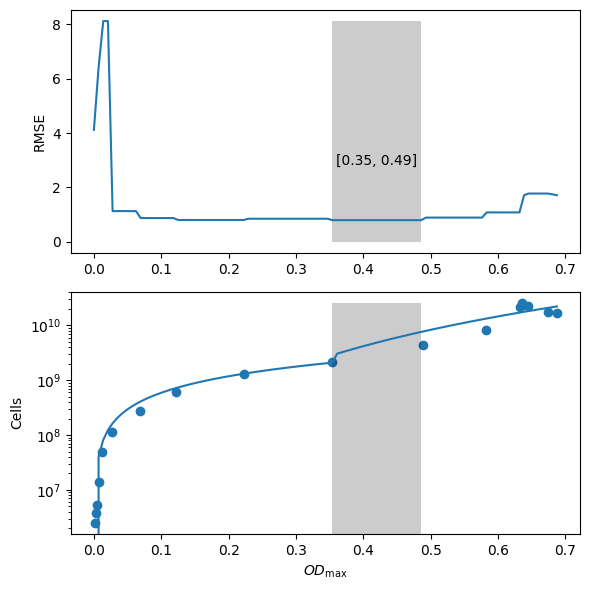

In [124]:
reg, odmax_domain, mse_scan = KFold_cell_count_regressor(od, cells, k=4)

# Chosen crossover is the minimum odmax value that achieves that mse,
# but we can highlight the range of equivalent values:
min_mse_mask = (mse_scan == mse_scan[np.where(odmax_domain == reg.crossover)])
min_mse_odmax = odmax_domain[min_mse_mask]

fig, (mse_ax, pred_ax) = plt.subplots(2, 1)
mse_ax.plot(odmax_domain, np.sqrt(mse_scan))
mse_ax.fill_between(min_mse_odmax, np.max(np.sqrt(mse_scan)),
                    step="pre", color="k", alpha=0.2, linewidth=0)
mse_ax.text(np.mean(min_mse_odmax), np.mean(mse_scan),
            f"[{reg.crossover:.2f}, {np.max(min_mse_odmax):.2f}]", horizontalalignment="center")
mse_ax.set_ylabel("RMSE")

pred_ax.plot(odmax_domain, reg.predict(odmax_domain))
pred_ax.scatter(od, cells)
pred_ax.fill_between(min_mse_odmax, np.max(
    cells), step="pre", color="k", alpha=0.2, linewidth=0)
pred_ax.set_yscale("log")
pred_ax.set_xlabel("$OD_{{\\max}}$")
pred_ax.set_ylabel("Cells")

fig.set_size_inches(6, 6)
fig.tight_layout()


In [125]:
reg.crossover

0.35399449035812675

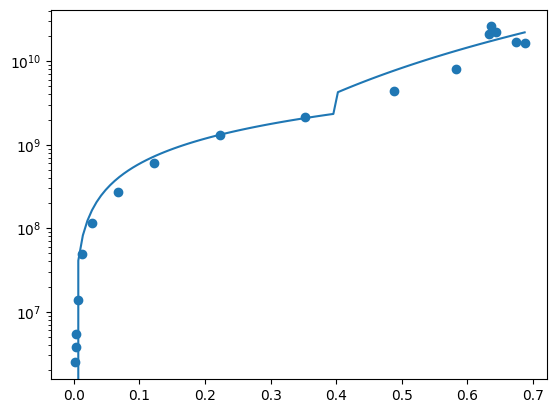

In [133]:
final_regressor = CellCountRegressor(crossover=0.4)
final_regressor.train(od, cells)

fig, ax = plt.subplots()
ax.scatter(od, cells)
x = np.linspace(0, np.max(od), 100)
ax.plot(x, final_regressor.predict(x))
ax.set_yscale("log")
